In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import src.python.yalefaces as yalefaces

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn import metrics

np.random.seed(15)

## Data preprocessing

### Load dataset

In [2]:
X, y = yalefaces.load("datasets/yalefaces", flatten=True)

In [88]:
X = X.astype("float32") / 255.0

### Plot dataset

<Figure size 432x288 with 0 Axes>

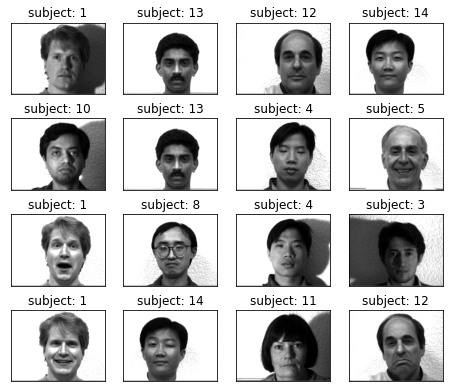

In [89]:
num_faces, num_pixels = X.shape

plt.figure()
f, axes = plt.subplots(4,4, figsize=(12, 10), sharey=True)
for ax in axes:
    for axy in ax:
        # select a random face
        face = np.random.randint(0, num_faces)
        
        # format image and label as in the raw dataset
        face_img = X[face].reshape(yalefaces.SHAPE)
        face_label = y[face] + 1

        # plot face
        axy.imshow(face_img, cmap='gray')
        
        # show only relevant information
        axy.set_title(f"subject: {face_label}")
        axy.set_xticks([])
        axy.set_yticks([])


plt.subplots_adjust(left=0.4, bottom=0.1, right=None, top=0.61, wspace=0.2, hspace=0.2)
plt.show()

### Identify most relevant pixels

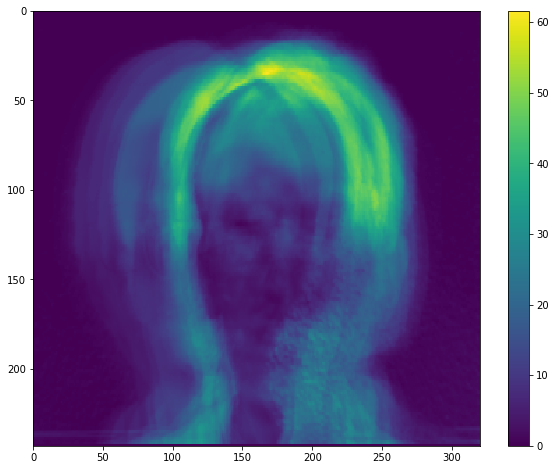

In [90]:
from sklearn.feature_selection import chi2

score, _ = chi2(X, y)
score_img = (np.array(score)).reshape(yalefaces.SHAPE)

plt.figure(figsize=(10, 8))

colormesh = plt.pcolormesh(score_img)
plt.colorbar(colormesh)

# mirror the y-axis because pcolormesh doesn't
# do this trick automatically as imgshow does.
plt.gca().invert_yaxis()
plt.show()

## Reduce number of dimensions

### Plot explained variance ratio

In [91]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(X)

PCA()

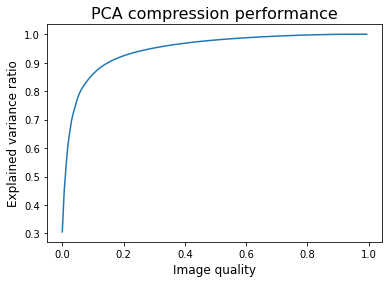

In [92]:
plt.plot(np.arange(num_faces)/165, np.cumsum(pca.explained_variance_ratio_))

plt.title("PCA compression performance", size=16)
plt.ylabel("Explained variance ratio", size=12)
plt.xlabel("Image quality", size=12)

plt.show()

### Choose image quality and compress images with PCA

In [93]:
image_quality = 1
n_components = int(num_faces * image_quality)

pca = PCA(n_components=n_components)
pca.fit(X)
X_compressed = pca.transform(X)
X_reconstructed = pca.inverse_transform(X_compressed)

In [114]:
image_quality = 1
n_components = int(num_faces * image_quality)

pca = PCA(n_components=n_components)
pca.fit(X)
X_compressed = pca.transform(X)

### Plot eigenfaces

<Figure size 432x288 with 0 Axes>

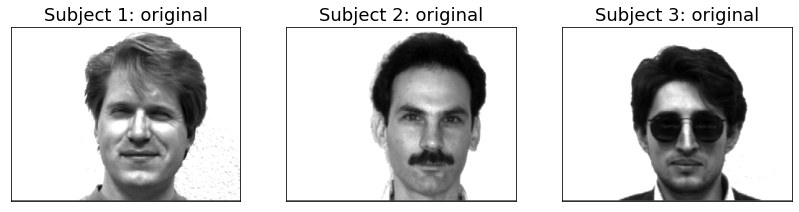

In [95]:
plt.figure()
f, axes = plt.subplots(1, 3, figsize=(14, 8), sharey=True)

subject = 0
for ax in axes:
    
    face = X[y==subject][0]
    face_img = face.reshape(yalefaces.SHAPE)
    ax.imshow(face_img, cmap='gray')

    ax.set_title(f"Subject {subject+1}: original", size=18)

    ax.set_xticks([])
    ax.set_yticks([])

    subject += 1

plt.show()

<Figure size 432x288 with 0 Axes>

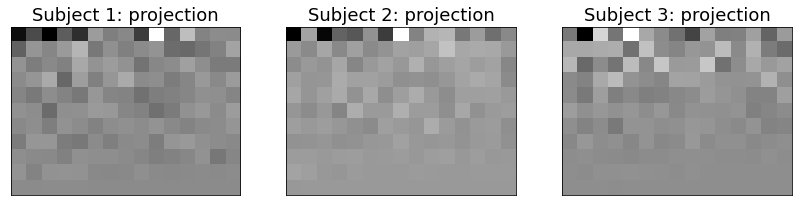

In [96]:
plt.figure()
f, axes = plt.subplots(1, 3, figsize=(14, 8), sharey=True)

subject = 0
for ax in axes:
    
    face = X_compressed[y==subject][0]
    face_img = face.reshape((11, 15))
    ax.imshow(face_img, cmap='gray')

    ax.set_title(f"Subject {subject+1}: projection", size=18)

    ax.set_xticks([])
    ax.set_yticks([])

    subject += 1

plt.show()

<Figure size 432x288 with 0 Axes>

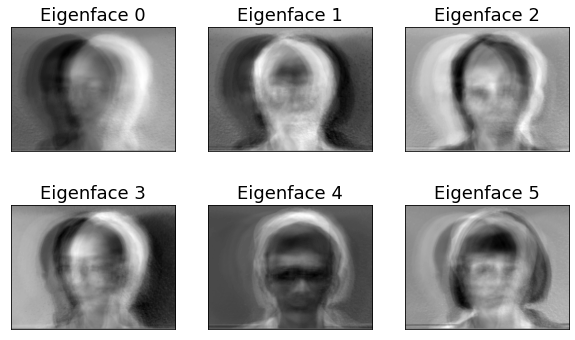

In [97]:
plt.figure()
f, axes = plt.subplots(2, 3, figsize=(10, 6), sharey=True)

component = 0
for ax in axes:
    for axy in ax:
        axy.imshow(pca.components_[component].reshape(yalefaces.SHAPE), cmap='gray')
        axy.set_title(f"Eigenface {component}", size=18)

        axy.set_xticks([])
        axy.set_yticks([])

        component += 1

plt.show()

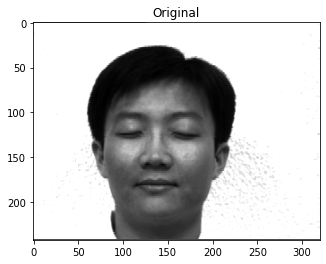

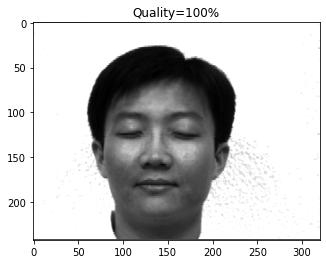

In [98]:
plt.imshow(X[0].reshape(yalefaces.SHAPE), cmap="gray")
plt.title("Original")
plt.show()

plt.imshow(X_reconstructed[0].reshape(yalefaces.SHAPE), cmap="gray")
plt.title(f"Quality={image_quality*100}%")
plt.show()

### Prepare datasets (original and compressed)

In [99]:
from sklearn.model_selection import train_test_split

# original
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True, stratify=y)

# compressed
X_train_compressed, X_test_compressed, y_train_compressed, y_test_compressed = train_test_split(X_compressed, y, test_size=0.3, random_state=42, shuffle=True, stratify=y)

In [100]:
rl = LogisticRegression(penalty="l2", C=1, solver='liblinear')
rl.fit(X_train_compressed, y_train_compressed)

LogisticRegression(C=1, solver='liblinear')

In [82]:
rl_pred = rl.predict(X_test_compressed)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       0.75      1.00      0.86         3
           2       0.75      1.00      0.86         3
           3       1.00      0.75      0.86         4
           4       1.00      1.00      1.00         3
           5       1.00      1.00      1.00         3
           6       1.00      1.00      1.00         4
           7       1.00      1.00      1.00         4
           8       1.00      1.00      1.00         3
           9       1.00      1.00      1.00         3
          10       1.00      1.00      1.00         4
          11       1.00      0.67      0.80         3
          12       1.00      1.00      1.00         4
          13       1.00      1.00      1.00         3
          14       1.00      1.00      1.00         3

    accuracy                           0.96        50
   macro avg       0.97      0.96      0.96        50
weighted avg       0.97   

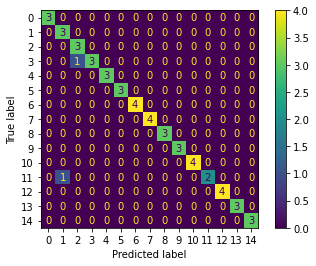

In [112]:
print(metrics.classification_report(y_test_compressed, rl_pred))
ConfusionMatrixDisplay.from_predictions(y_test_compressed, rl_pred)

In [83]:
knn = KNeighborsClassifier(n_neighbors=3, algorithm='ball_tree', weights='distance', metric='euclidean')
knn.fit(X_train_compressed, y_train_compressed)

KNeighborsClassifier(algorithm='ball_tree', metric='euclidean', n_neighbors=3,
                     weights='distance')

In [84]:
knn_pred = knn.predict(X_test_compressed)

In [50]:
mlp = MLPClassifier(hidden_layer_sizes=(200, 100), activation='tanh', solver='adam', alpha=1, learning_rate='constant', max_iter=7600)
mlp.fit(X_train_compressed, y_train_compressed)

MLPClassifier(activation='tanh', alpha=1, hidden_layer_sizes=(200, 100),
              max_iter=7600)

In [119]:
# Build a simple model
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

def build(lr=0.01, solver='sgd'):
    inputs = keras.Input(shape=(77760,))
    x = layers.Dense(500, activation="tanh")(inputs)
    x = layers.Dense(400, activation="tanh")(x)
    x = layers.Dense(300, activation="tanh")(x)
    x = layers.Dense(200, activation="tanh")(x)
    x = layers.Dense(100, activation="tanh")(x)
    outputs = layers.Dense(15, activation="softmax")(x)
    
    model = keras.Model(inputs, outputs)
    model.compile(optimizer=solver, loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    return model


batch_size = 64

mlp2 = build()
history = mlp2.fit(X_train, y_train, epochs=200, validation_data=(X_test, y_test))

Epoch 1/200
4/4 [==============================] - 1s 68ms/step - loss: 2.8568 - accuracy: 0.0957 - val_loss: 2.7290 - val_accuracy: 0.0800
Epoch 2/200
4/4 [==============================] - 0s 19ms/step - loss: 2.6488 - accuracy: 0.0783 - val_loss: 2.6191 - val_accuracy: 0.1400
Epoch 3/200
4/4 [==============================] - 0s 18ms/step - loss: 2.5920 - accuracy: 0.1739 - val_loss: 2.5508 - val_accuracy: 0.0600
Epoch 4/200
4/4 [==============================] - 0s 18ms/step - loss: 2.4994 - accuracy: 0.1652 - val_loss: 2.4244 - val_accuracy: 0.3200
Epoch 5/200
4/4 [==============================] - 0s 18ms/step - loss: 2.3225 - accuracy: 0.2783 - val_loss: 2.3474 - val_accuracy: 0.2800
Epoch 6/200
4/4 [==============================] - 0s 20ms/step - loss: 2.2106 - accuracy: 0.2870 - val_loss: 2.5112 - val_accuracy: 0.2200
Epoch 7/200
4/4 [==============================] - 0s 19ms/step - loss: 2.4500 - accuracy: 0.2000 - val_loss: 2.3525 - val_accuracy: 0.2600
Epoch 8/200
4/4 [===

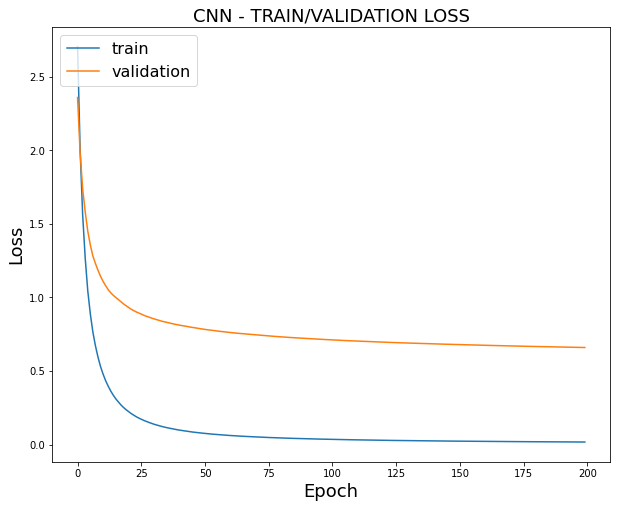

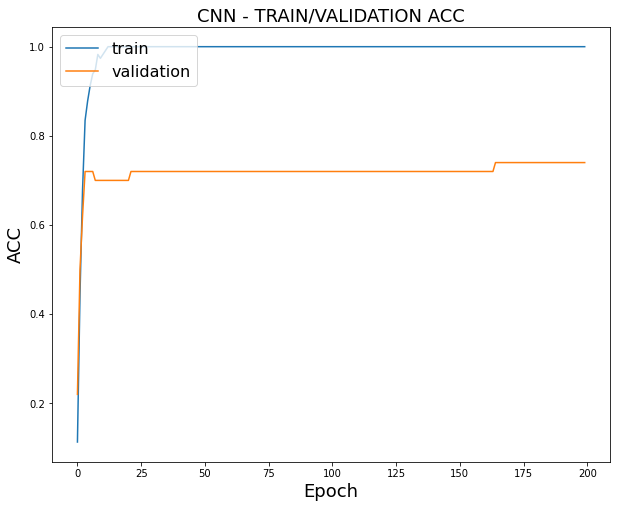

In [117]:
plt.figure(figsize=(10, 8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('CNN - TRAIN/VALIDATION LOSS', size=18)
plt.ylabel('Loss', size=18)
plt.xlabel('Epoch', size=18)
plt.legend(['train', 'validation'], loc='upper left', fontsize=16)
plt.show()

plt.figure(figsize=(10, 8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('CNN - TRAIN/VALIDATION ACC', size=18)
plt.ylabel('ACC', size=18)
plt.xlabel('Epoch', size=18)
plt.legend(['train', 'validation'], loc='upper left', fontsize=16)
plt.show()

In [51]:
mlp_pred = mlp.predict(X_test_compressed)

## Logistic Regression

### Train and test on the original dataset

In [ ]:
lr_param_grid = [{'C':[0.00001, 0.0001, 0.001, 0.01, 0.01, 1], 'max_iter':[7600]}]
lr_grid_search = GridSearchCV(estimator = LogisticRegression(), 
    param_grid = lr_param_grid, scoring = 'accuracy', cv = 5, return_train_score=True)

lr_classifier = lr_grid_search.fit(X_train, y_train)

In [ ]:
print("Train score (original):", lr_grid_search.best_score_)
print("Best params (original):", lr_grid_search.best_params_)
lr_cv_result = pd.DataFrame(lr_grid_search.cv_results_)
lr_cv_result.head()

In [ ]:
print("Train score (original):", lr_grid_search.best_score_)
print("Best params (original):", lr_grid_search.best_params_)

print("Score (original):", lr_classifier.score(X_test, y_test))
print(lr_grid_search.best_params_)

lr_pred = lr_classifier.predict(X_test)
print(metrics.classification_report(y_test, lr_pred))
ConfusionMatrixDisplay.from_predictions(y_test, lr_pred)

### Train and test on the compressed dataset

In [ ]:
lr_grid_search_compressed = GridSearchCV(estimator = LogisticRegression(), 
    param_grid = lr_param_grid, scoring = 'accuracy', cv = 5, return_train_score=True)

lr_classifier_compressed = lr_grid_search_compressed.fit(X_train_compressed, y_train_compressed)

In [ ]:
print("Train score (original):", lr_grid_search_compressed.best_score_)
print("Best params (original):", lr_grid_search_compressed.best_params_)
lr_cv_result_compressed = pd.DataFrame(lr_grid_search_compressed.cv_results_)
lr_cv_result_compressed.head()

In [ ]:
print("Score (compressed):", lr_classifier_compressed.score(X_test_compressed, y_test_compressed))

lr_pred_compressed = lr_classifier_compressed.predict(X_test_compressed)
print(metrics.classification_report(y_test_compressed, lr_pred_compressed))
ConfusionMatrixDisplay.from_predictions(y_test_compressed, lr_pred_compressed)

## KNN

### Train and test on the original dataset

In [ ]:
knn_param_grid = [{'C':[0.00001, 0.0001, 0.001, 0.01, 0.01, 1], 'max_iter':[7600]}]
lr_grid_search = GridSearchCV(estimator = KNeighborsClassifier(), 
    param_grid = knn_param_grid, scoring = 'accuracy', cv = 5, verbose=0)

knn_classifier = KNeighborsClassifier(n_neighbors=2)
knn_classifier.fit(X_train, y_train)

In [ ]:
print("Score (original):", knn_classifier.score(X_test, y_test))

knn_pred = knn_classifier.predict(X_test)
ConfusionMatrixDisplay.from_predictions(y_test, knn_pred)

### Train and test on the compressed dataset

In [ ]:
knn_classifier_compressed = KNeighborsClassifier(n_neighbors=2)
knn_classifier_compressed.fit(X_train_compressed, y_train_compressed)

In [ ]:
print("Score (compressed):", knn_classifier_compressed.score(X_test_compressed, y_test_compressed))

knn_pred_compressed = knn_classifier_compressed.predict(X_test_compressed)
ConfusionMatrixDisplay.from_predictions(y_test_compressed, knn_pred_compressed)

## Neural Networks

### Train and test on the original dataset

In [13]:
mlp_param_grid = [{'hidden_layer_sizes':[(512, 256, 128, 64), (256, 128, 64), (128, 64)], 'max_iter':[7600], 'alpha': [0.0001, 0.001, 0.01, 0.1, 1], 'solver': ['adam', 'sgd'], 'activation': ['relu', 'logistic']}]

In [14]:
mlp_grid_search = GridSearchCV(estimator = MLPClassifier(random_state=1), param_grid = mlp_param_grid, scoring = 'accuracy', cv = 5, verbose=1)

mlp_classifier = mlp_grid_search.fit(X_train, y_train)
mlp_classifier.fit(X_train, y_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


/home/jeff/.local/lib/python3.8/site-packages/sklearn/utils/extmath.py:152: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/home/jeff/.local/lib/python3.8/site-packages/sklearn/neural_network/_base.py:66: RuntimeWarning: invalid value encountered in subtract
  tmp = X - X.max(axis=1)[:, np.newaxis]
/home/jeff/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:709: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/home/jeff/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:709: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/home/jeff/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:709: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


: 

In [ ]:
print("Train score (original):", mlp_classifier.best_score_)
print("Best params (original):", mlp_classifier.best_params_)
mlp_cv_result = pd.DataFrame(mlp_classifier.cv_results_)
mlp_cv_result.head()

In [15]:
mlp_classifier = MLPClassifier(solver='adam', learning_rate_init=0.1, random_state=1, hidden_layer_sizes=(500, 400, 300, 200, 100))
mlp_classifier.fit(X_train, y_train)

MLPClassifier(hidden_layer_sizes=(500, 400, 300, 200, 100),
              learning_rate_init=0.1, random_state=1)

In [14]:
mlp_classifier = MLPClassifier(solver='adam', learning_rate_init=0.1, random_state=1, hidden_layer_sizes=(500, 400, 300, 200, 100))
mlp_classifier.fit(X_train_compressed, y_train)

MLPClassifier(hidden_layer_sizes=(500, 400, 300, 200, 100),
              learning_rate_init=0.1, random_state=1)

Score (original): 0.06


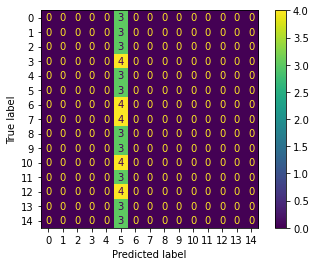

In [16]:
print("Score (original):", mlp_classifier.score(X_test, y_test))

mlp_pred= mlp_classifier.predict(X_test)
ConfusionMatrixDisplay.from_predictions(y_test, mlp_pred)

### Train and test on the compressed dataset

In [ ]:
mlp_classifier_compressed = MLPClassifier(solver='adam', learning_rate_init=0.1, random_state=1)
mlp_classifier_compressed.fit(X_train_compressed, y_train_compressed)

In [ ]:
print("Score (compressed):", mlp_classifier_compressed.score(X_test_compressed, y_test_compressed))

mlp_pred_compressed = mlp_classifier_compressed.predict(X_test_compressed)
ConfusionMatrixDisplay.from_predictions(y_test_compressed, mlp_pred_compressed)

## Convolutional Neural Networks

In [14]:
from keras import backend as K
from keras.optimizers import SGD
from src.python.models.lenet import LeNet

# cnn = LeNet.build(numChannels=1, imgRows=243, imgCols=320, numClasses=15, weightsPath=None)

# cnn.compile(loss="categorical_crossentropy", optimizer=SGD(learning_rate=0.01), metrics=["accuracy"])


In [15]:
from keras.utils import to_categorical

if K.image_data_format() == "channels_first":
	cnn_trainX = X_train.reshape((X_train.shape[0], 1, 243, 320))
	cnn_testX = X_test.reshape(X_test.shape[0], 1, 243, 320)
else:
	cnn_trainX = X_train.reshape(X_train.shape[0], 243, 320, 1)
	cnn_testX = X_test.reshape(X_test.shape[0], 243, 320, 1)


# scale data to the range of [0, 1]
cnn_trainX = cnn_trainX.astype("float32") / 255.0
cnn_testX = cnn_testX.astype("float32") / 255.0


cnn_train_y = to_categorical(y_train)
cnn_test_y = to_categorical(y_test)

In [23]:
import os
import time
from sklearn.model_selection import KFold
import tensorflow as tf

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

kf = KFold(n_splits=3)
kf.get_n_splits(cnn_trainX)

best_num_filters = None
best_filters_sizes = None
best_acc = 0
best_model = None
for num_filters in [[76, 48, 32], [48, 32, 24]]:
    for filter_sizes in [[3, 3, 3], [5, 5, 5], [5,3,1]]:
        print(f"testing num_filters={num_filters}, filter_sizes={filter_sizes}")
        start = time.time()
        acc_sum = 0
        n = 0
        for train_index, test_index in kf.split(cnn_trainX):
            X_tr, X_te = cnn_trainX[train_index], cnn_trainX[test_index]
            y_tr, y_te = cnn_train_y[train_index], cnn_train_y[test_index]

            # tf.keras.backend.clear_session()

            cnn = LeNet.build(numChannels=1, imgRows=243, imgCols=320, numClasses=15, activation='relu', weightsPath=None, num_filters=num_filters, filter_sizes=filter_sizes, dense_width=128)
            cnn.fit(X_tr, y_tr, batch_size=8, epochs=20, verbose=0)

            (loss, accuracy) = cnn.evaluate(X_te, y_te, batch_size=8, verbose=1)
            
            acc_sum += accuracy
            n += 1

        mean_acc = acc_sum/n
        if mean_acc > best_acc:
            best_acc = mean_acc

            best_model = cnn
            best_num_filters = num_filters
            best_filters_sizes = filter_sizes

            print(f"Current best num_filters: {num_filters} - filter_sizes: {filter_sizes}, mean_acc: {mean_acc}")

        end = time.time()
        print(end - start)


testing num_filters=[76, 48, 32], filter_sizes=[3, 3, 3]
5/5 [==============================] - 0s 10ms/step - loss: 0.5458 - accuracy: 0.9211
Current best num_filters: [76, 48, 32] - filter_sizes: [3, 3, 3], mean_acc: 0.9046333829561869
15.267873287200928
testing num_filters=[76, 48, 32], filter_sizes=[5, 5, 5]
5/5 [==============================] - 0s 13ms/step - loss: 1.1415 - accuracy: 0.8684
19.751879453659058
testing num_filters=[76, 48, 32], filter_sizes=[5, 3, 1]
5/5 [==============================] - 0s 9ms/step - loss: 0.3843 - accuracy: 0.8947
15.01105809211731
testing num_filters=[48, 32, 24], filter_sizes=[3, 3, 3]
5/5 [==============================] - 0s 7ms/step - loss: 0.6253 - accuracy: 0.8947
10.992860317230225
testing num_filters=[48, 32, 24], filter_sizes=[5, 5, 5]
5/5 [==============================] - 0s 9ms/step - loss: 0.6963 - accuracy: 0.8947
Current best num_filters: [48, 32, 24] - filter_sizes: [5, 5, 5], mean_acc: 0.9048582911491394
13.296271324157715
test

In [24]:
print(f"[BEST] num_filters: {best_num_filters} - filter_sizes: {best_filters_sizes}")
cnn = LeNet.build(numChannels=1, imgRows=243, imgCols=320, numClasses=15, activation='relu', weightsPath=None, num_filters=best_num_filters, filter_sizes=best_filters_sizes, dense_width=128)
history = cnn.fit(cnn_trainX, cnn_train_y, batch_size=8, epochs=25, verbose=0, validation_data=(cnn_testX, cnn_test_y))

[BEST] num_filters: [48, 32, 24] - filter_sizes: [5, 5, 5]


In [50]:
print(best_acc)

0.931174099445343


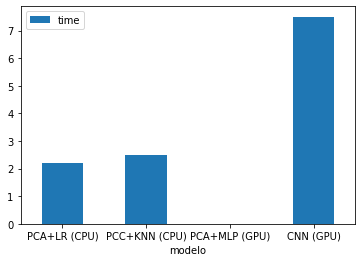

In [125]:
import pandas as pd
df = pd.DataFrame({'modelo':['PCA+LR (CPU)', 'PCC+KNN (CPU)', 'PCA+MLP (GPU)', 'CNN (GPU)'], 'time':[2.2, 2.5, 0, 7.5]})
ax = df.plot.bar(x='modelo', y='time', rot=0)

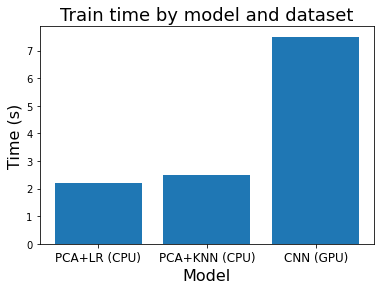

In [134]:
plt.bar([0,1,2], [2.2, 2.5, 7.5])
plt.title('Train time by model and dataset', size=18)
plt.ylabel('Time (s)', size=16)
plt.xlabel('Model', size=16)
plt.xticks(ticks=[0,1,2], labels=['PCA+LR (CPU)', 'PCA+KNN (CPU)', 'CNN (GPU)'], fontsize=12)
plt.show()

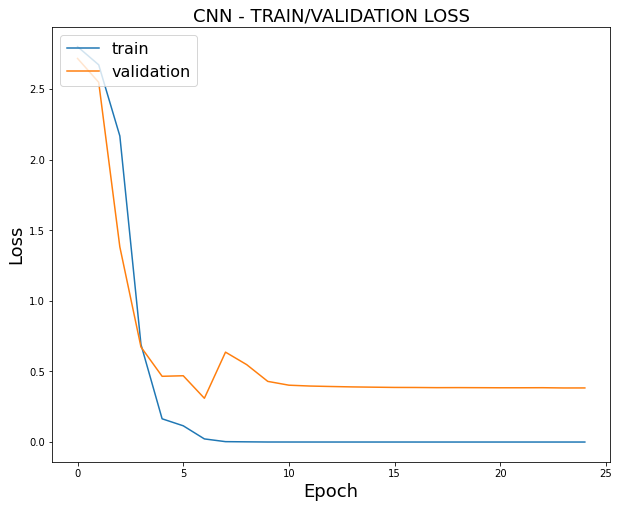

In [42]:
plt.figure(figsize=(10, 8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('CNN - TRAIN/VALIDATION LOSS', size=18)
plt.ylabel('Loss', size=18)
plt.xlabel('Epoch', size=18)
plt.legend(['train', 'validation'], loc='upper left', fontsize=16)
plt.show()

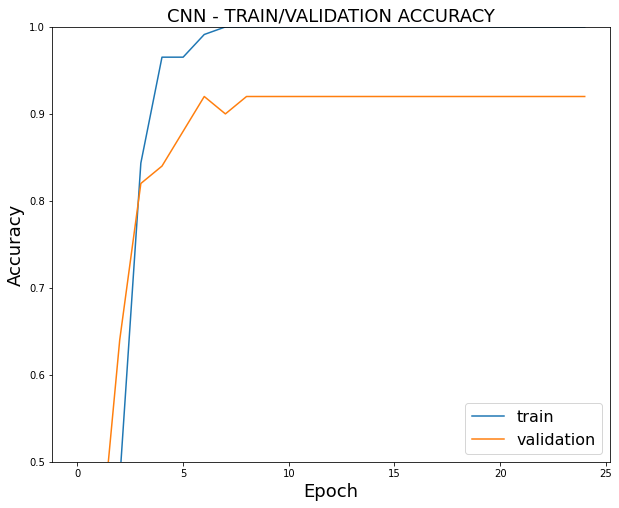

In [43]:
plt.figure(figsize=(10, 8))

plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')

plt.title('CNN - TRAIN/VALIDATION ACCURACY', size=18)

plt.xlabel('Epoch', size=18)
plt.ylabel('Accuracy', size=18)

plt.ylim([0.5, 1])

plt.legend(loc='lower right', fontsize=16)

In [27]:
(loss, accuracy) = cnn.evaluate(cnn_testX, cnn_test_y, batch_size=16, verbose=1)

4/4 [==============================] - 0s 10ms/step - loss: 0.3831 - accuracy: 0.9200


2/2 [==============================] - 0s 22ms/step - loss: 0.0908 - accuracy: 0.9800
Score (original): [0.09082040190696716, 0.9800000190734863]
2/2 [==============================] - 0s 23ms/step


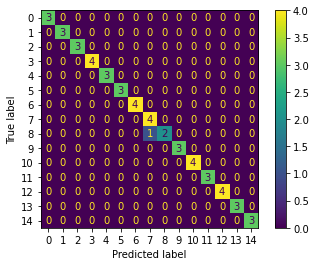

In [47]:
print("Score (original):", cnn.evaluate(cnn_testX, cnn_test_y))
y_pred = cnn.predict(cnn_testX)
ConfusionMatrixDisplay.from_predictions(np.argmax(cnn_test_y, axis=1), np.argmax(y_pred, axis=1))

In [49]:
print(np.argmax(y_pred[0]))

print(np.argmax(cnn_test_y[0]))


print(np.argmax(y_pred, axis=1) != np.argmax(cnn_test_y, axis=1))
print()

11
11
[False False False False False False  True False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False]
